# COGS 108 - EDA Checkpoint

# Names

- Tyler Le
- Aditya Tomar
- William Lynch
- Michael Mao
- Natalie Quach

<a id='research_question'></a>
# Research Question

Is there a positive correlation between the cost of living and the impact of natural disasters in terms of injuries, casualties, and property damage per capita at the county level? Furthermore, in which state does the impact of natural disasters affect cost of living the most?

# Setup

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from tqdm import tqdm # progress bar for .apply()

import plotly.express as px
import plotly.figure_factory as ff

from urllib.request import urlopen
import json

import warnings
warnings.filterwarnings('ignore')

# Statmodels & patsy
import patsy
import statsmodels.api as sm

# Make plots just slightly bigger for displaying well in notebook
plt.rcParams['figure.figsize'] = (10, 5)

## Clean Table #3 (NRI)

In [40]:
# # Look at the "NRI Data Dictionary in the datasets/NRI_Table_Counties" to see what the cols mean
# # EAL = "Expected Annual Lost", quantifies the anticipated economic damage resulting from natural hazards each year. 
# # 1-100 scale

# df_nri = pd.read_csv('datasets/NRI_Table_Counties/NRI_Table_Counties.csv')

# # select a subset of the columns
# wanted_cols = ['STATE','STATEABBRV','STATEFIPS','COUNTY','COUNTYFIPS','POPULATION','AREA','RISK_SCORE','RISK_RATNG','EAL_SCORE','EAL_RATNG']
# df_nri = df_nri[wanted_cols]

# # lowercase all columns
# df_nri.columns = df_nri.columns.str.lower()

# # rename columns
# df_nri = df_nri.rename(columns={"stateabbrv":"state_abbrv", "risk_ratng":"risk_rating" ,"eal_ratng":"eal_rating","countyfips":"county_fips","statefips":"state_fips"})

# # make sure there are no NaNs
# assert(df_nri.isna().sum().sum() == 0)

# df_nri
df_nri = pd.read_csv('datasets/cleaned/nri.csv')

# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

## EDA on Table #3
- Distribution of eal_score and risk_score
- Counties with the highest/lowest score
- Linear regression between risk score and frequency of natural disasters
- Linear regression between eal_score and frequency of natural disasters
- Correlation between risk_score and eal_score

### Let's see some distributions

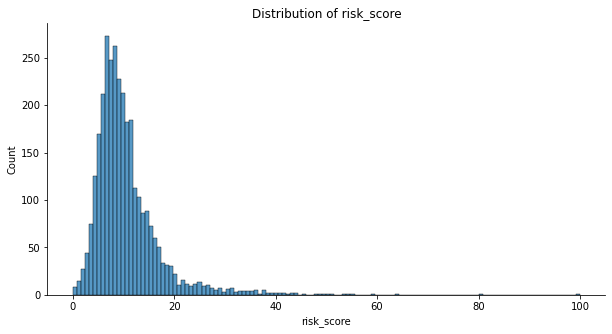

In [41]:
# get distribution of risk score
plot = sns.histplot(x='risk_score', data = df_nri)
plot.set_title('Distribution of risk_score')
sns.despine()

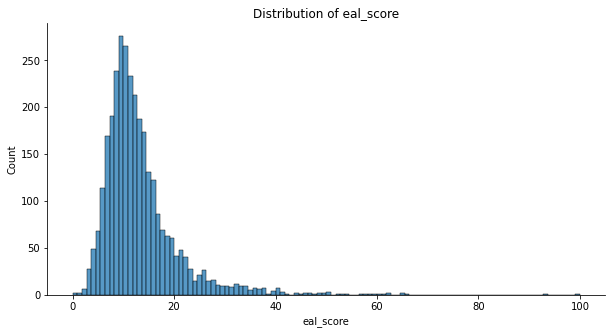

In [42]:
# get distribution of eal score
plot = sns.histplot(x='eal_score', data = df_nri)
plot.set_title('Distribution of eal_score')
sns.despine()

The two distributions don't look normally distributed so let's log-transform them.

In [43]:
df_nri['risk_score_log10'] = np.log10(df_nri['risk_score']) 
df_nri['eal_score_log10'] = np.log10(df_nri['eal_score']) 

Let's see the log-transformed distributions.

In [44]:
def standardize_risk_score_log10(num):
    if num == float('-inf'):
        output = -.3
    else:
        output = num
    return output

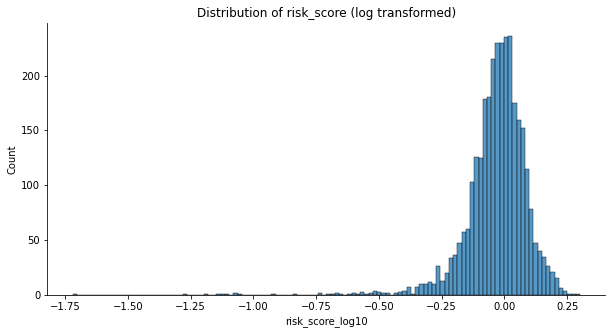

In [45]:
# get distribution of risk score (log-transformed)
df_nri['risk_score_log10'] = np.log10(df_nri['risk_score_log10']).apply(standardize_risk_score_log10) 
plot = sns.histplot(x='risk_score_log10', data = df_nri)
plot.set_title('Distribution of risk_score (log transformed)')
sns.despine()

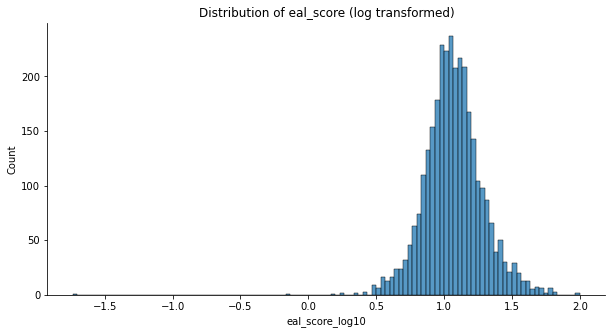

In [46]:
# get distribution of eal score (log-transformed)
plot = sns.histplot(x='eal_score_log10', data = df_nri)
plot.set_title('Distribution of eal_score (log transformed)')
sns.despine()

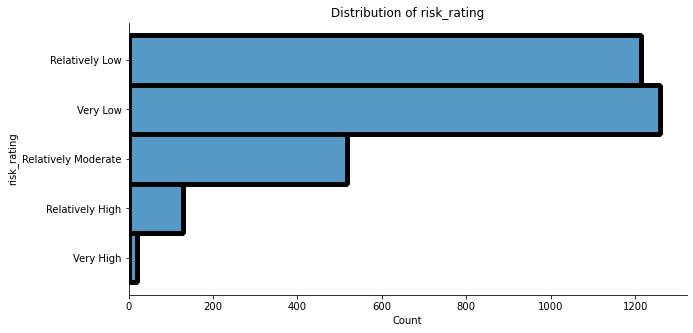

In [47]:
# get distribution of risk_rating

plot = sns.histplot(y='risk_rating', data = df_nri)
plot.set_title('Distribution of risk_rating')
sns.despine()

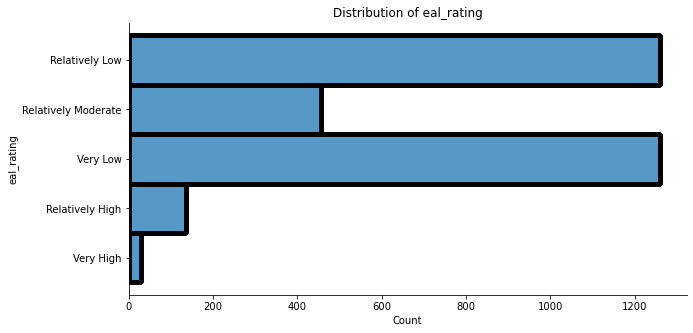

In [48]:
# get distribution of eal_rating
plot = sns.histplot(y='eal_rating', data = df_nri)
plot.set_title('Distribution of eal_rating')
sns.despine()

### Let's see which counties have the highest eal_score and risk_score

In [49]:
df_nri.sort_values(by = ['eal_score'], ascending = False).head()

state state_abbrv  state_fips       county  county_fips  \
1271  California          CA           6  Los Angeles           37   
2623       Texas          TX          48       Harris          201   
1295  California          CA           6  Santa Clara           85   
1285  California          CA           6    Riverside           65   
1253  California          CA           6      Alameda            1   

      population         area  risk_score      risk_rating   eal_score  \
1271     9818605  4058.076752  100.000000        Very High  100.000000   
2623     4092459  1704.918916   80.618536        Very High   93.636473   
1295     1781642  1291.210369   22.951107  Relatively High   66.140195   
1285     2189641  7206.325086   58.865953        Very High   64.985716   
1253     1510271   737.476821   40.402820  Relatively High   64.799506   

     eal_rating   fips  risk_encoded  eal_encoded  risk_score_log10  \
1271  Very High   6037             5            5          0.301030   
2623  Very High  48201             5            5          0.280222   
1295  Very High   6085             4            5          0.133795   
1285  Very High   6065             5            5          0.247940   
1253  Very High   6001             4            5          0.205857   

      eal_score_log10  
1271         2.000000  
2623         1.971445  
1295         1.820465  
1285         1.812818  
1253         1.811572

In [50]:
df_nri.sort_values(by = ['risk_score'], ascending = False).head()

state state_abbrv  state_fips       county  county_fips  \
1271  California          CA           6  Los Angeles           37   
2623       Texas          TX          48       Harris          201   
1429     Florida          FL          12   Miami-Dade           86   
1285  California          CA           6    Riverside           65   
828     New York          NY          36        Bronx            5   

      population         area  risk_score risk_rating   eal_score  \
1271     9818605  4058.076752  100.000000   Very High  100.000000   
2623     4092459  1704.918916   80.618536   Very High   93.636473   
1429     2496435  1898.662364   63.926384   Very High   46.243703   
1285     2189641  7206.325086   58.865953   Very High   64.985716   
828      1385108    42.050624   55.547136   Very High   25.603947   

               eal_rating   fips  risk_encoded  eal_encoded  risk_score_log10  \
1271            Very High   6037             5            5          0.301030   
2623            Very High  48201             5            5          0.280222   
1429            Very High  12086             5            5          0.256641   
1285            Very High   6065             5            5          0.247940   
828   Relatively Moderate  36005             5            3          0.241711   

      eal_score_log10  
1271         2.000000  
2623         1.971445  
1429         1.665053  
1285         1.812818  
828          1.408307

### Let's create a choropleth of all counties risk_score in the US

In [51]:
# we need state and county FIPS information (already included in NRI dataset)
df_nri['state_fips'] = df_nri['state_fips'].apply(lambda x: str(x).zfill(2))
df_nri['county_fips'] = df_nri['county_fips'].apply(lambda x: str(x).zfill(3))
df_nri['fips'] = df_nri['state_fips'] + df_nri['county_fips']

with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

### Choropleth for risk score

In [52]:
# View the color options below
# https://plotly.com/python/builtin-colorscales/

fig = px.choropleth(df_nri, geojson=counties, locations='fips', color='risk_score',
                           color_continuous_scale="OrRd",
                           range_color=(0, 25),
                           scope="usa",
                           labels={'risk_score':'risk score'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show(renderer="svg")

### Choropleth for eal_score

In [53]:
fig = px.choropleth(df_nri, geojson=counties, locations='fips', color='eal_score',
                           color_continuous_scale="Burgyl",
                           range_color=(0, 25),
                           scope="usa",
                           labels={'eal_score':'eal score'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show(renderer="svg")

### We can use linear regression to see the correlation between risk_score and expected annual loss.

We will use the log-transformed values.

This should be trivially correlated as when natural disaster risk goes up, so should expected annual loss.

In [54]:
outcome, predictors = patsy.dmatrices('risk_score_log10 ~ eal_score_log10', df_nri)

mod_log = sm.OLS(outcome, predictors)
res_log = mod_log.fit()
print(res_log.summary())

                            OLS Regression Results                            
Dep. Variable:       risk_score_log10   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     2549.
Date:                Sun, 20 Feb 2022   Prob (F-statistic):               0.00
Time:                        17:20:31   Log-Likelihood:                 2829.3
No. Observations:                3133   AIC:                            -5655.
Df Residuals:                    3131   BIC:                            -5642.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.4801      0.009    -

In [55]:
### Create a scatter matrix to see correlations

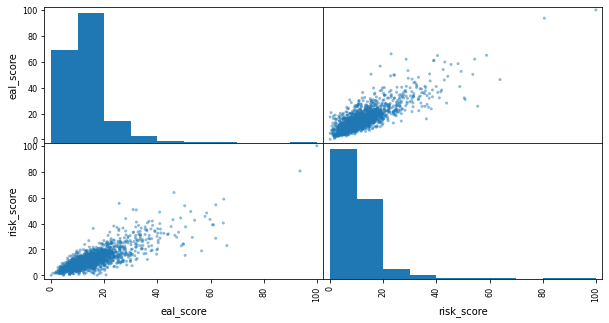

In [56]:
fig = pd.plotting.scatter_matrix(df_nri[['eal_score','risk_score']])